In [15]:
# Load libraries, add helpful functions

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import csv
import os, sys
from dateutil.relativedelta import relativedelta

def get_fields(field_file):
    with open(field_file, 'r') as f:
        return list(csv.reader(f))[0]  # assume only one line

In [28]:
# Read in files and initial data frames, offense codes, and county codes

df = pd.read_csv('./data/3drugs.csv', dtype={'CRRKCY': str, 'CROFFC': int})
fields = pd.read_csv('./data/fields.csv', index_col='field')
marijuana_offense_codes = pd.read_csv(
    './data/offense_codes_marijuana.csv')['code'].tolist()
cocaine_offense_codes = pd.read_csv(
    './data/offense_codes_cocaine.csv')['code'].tolist()
heroin_offense_codes = pd.read_csv(
    './data/offense_codes_heroin.csv')['code'].tolist()
county_codes = pd.read_csv(
    './data/county_codes.csv', dtype={'code': str}).set_index('code')['county'].to_dict()

In [29]:
# Clean up main data frame before breaking into different data frames by drug

df = df[fields.index.tolist()]  # limit data frame to desired fields
df.rename(columns=fields['description'].to_dict(), inplace=True)
df = df.replace({'.': np.nan})
df['County'] = df['County_Number'].map(county_codes) # Make new column with column names based on column numbers
df['Defendant_Race'] = df['Defendant_Race_Code'].map({'A':'Asian', 'B': 'Black', 'H': 'Hispanic', 'I':'Indian', 'O': 'Other', 'U': 'Unknown', 'W': 'White', 'X': 'Non-person'}) # Create new column to map races
df['Probation_Length'].replace({'.':0})
df['Filing_Date'] = pd.to_datetime(df['Filing_Date'])
df['Year'] = pd.to_datetime(df['File_Number_Century'] * 100 + df['File_Number_Year'], format='%Y') # Convert century and year to single column
df.drop(['File_Number_Century','File_Number_Year'], inplace=True, axis=1) # Drop old columns

# Datetime Conversion
datetime_columns = ['Defendant_Date_of_Birth', 'Filing_Date', 'Case_Trial_Date', 'Charged_Offense_Date', 'Arraigned_Offense_Date',]
df[datetime_columns] = df[datetime_columns].apply(pd.to_datetime, errors='coerce', format='%Y-%m-%d')
df['Age'] = (df['Filing_Date'] - df['Defendant_Date_of_Birth']).dt.days // 365
df[df['Age'] <= 0] = np.nan

# Change probation length to all be in terms of days - number may be a few days off because of simplification
# that month is 30 days and year is 365 days
df['Probation_Frame'].replace({'Y': 365, 'M': 30, 'D': 1, '.': np.nan}, inplace=True)
df['Probation_Length'] = df['Probation_Length'].replace({'.': np.nan}).astype(float) * df['Probation_Frame']

/Users/jacklm/Documents/UNC/POLI 490H/poli490h/venv/lib/python3.7/site-packages/pandas/core/frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [18]:
# Limit to different types of drug offenses

marijuana = df[df['Charged_Offense_Code'].isin(marijuana_offense_codes)]
cocaine = df[df['Charged_Offense_Code'].isin(cocaine_offense_codes)]
heroin = df[df['Charged_Offense_Code'].isin(heroin_offense_codes)]

Text(0, 0.5, 'Count')

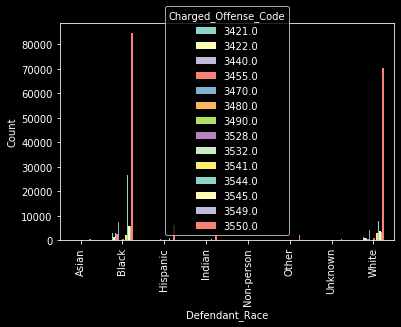

In [20]:
# Plot offense code count separated by race to find which offense codes each race faces most

marijuana.groupby(['Defendant_Race', 'Charged_Offense_Code']).count()['County'].unstack('Charged_Offense_Code').plot.bar()
plt.ylabel('Count')

Text(0, 0.5, 'Count')

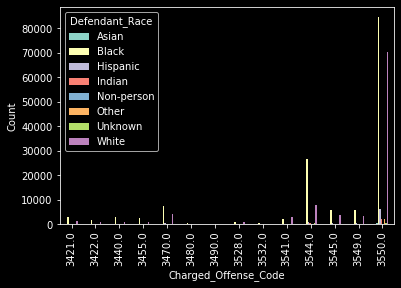

In [21]:
# Plot offense code count with each race compared side by side to see what races are charged the most and least with each

marijuana.groupby(['Defendant_Race', 'Charged_Offense_Code']).count()['County'].unstack('Defendant_Race').plot.bar()
plt.ylabel('Count')

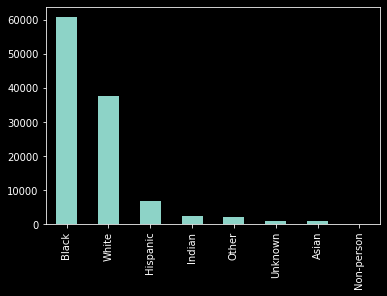

In [22]:
# Plot number of charges for each race

cols = ['Defendant_Race', 'File_Number_Sequence']
marijuana_race_counts = marijuana[cols].drop_duplicates()['Defendant_Race'].value_counts()
marijuana_race_counts.plot(kind='bar')

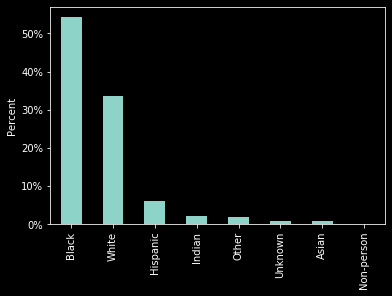

In [23]:
# Same as above, but as percentage

from matplotlib.ticker import FuncFormatter

marijuana_race_pct = marijuana_race_counts / marijuana_race_counts.sum()
ax = marijuana_race_pct.plot.bar()
plt.ylabel('Percent')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

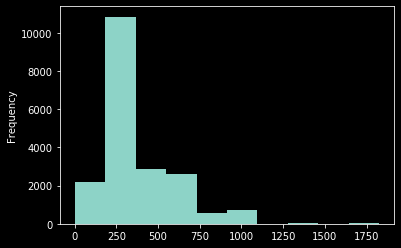

In [24]:
# Plot distribution of probation length for marijuana crimes in general


# Need to groupby to not double count same cases
marijuana['Probation_Length'].dropna().plot.hist()

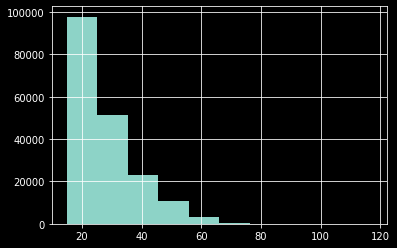

In [55]:
# Plot age - gets rid of duplicate file numbers

marijuana[['Age', 'File_Number_Sequence']].drop_duplicates()['Age'].hist()

In [26]:
import geopandas as gpd


zip_code_counts = marijuana['Defendant_Address_Zip_Code'].dropna().value_counts()
zip_code_counts = pd.DataFrame({'Defendant_Address_Zip_Code': zip_code_counts.index, 'count': zip_code_counts})
zip_code_counts[['count', 'Defendant_Address_Zip_Code']] = zip_code_counts[['count', 'Defendant_Address_Zip_Code']].astype(int)
nc_zip_codes = gpd.read_file('./data/nc_zip_codes.json')

In [34]:
# nc_zip_codes.drop(['STATEFP10', 'FUNCSTAT10'], inplace=True, axis=1)
# nc_zip_codes.rename({'ZCTA5CE10': 'Defendant_Address_Zip_Code'}, inplace=True, axis=1)
# nc_zip_codes['Defendant_Address_Zip_Code'] = nc_zip_codes['Defendant_Address_Zip_Code'].apply(int)
nc_zip_codes.join(zip_code_counts, on='Defendant_Address_Zip_Code')
nc_zip_codes.dtypes

ValueError: You are trying to merge on int64 and object columns. If you wish to proceed you should use pd.concat